<a href="https://colab.research.google.com/github/Al3927/charges_regression_analysis/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><font size ="9"> ĐỒ ÁN 01: REGRESSION</font></center>
 <br />
 
__TÊN MÔN HỌC:__ NHẬP MÔN HỌC MÁY

__ĐỀ TÀI:__ CHI PHÍ SỬ DỤNG DỊCH VỤ Y TẾ

__GIẢNG VIÊN:__ NGUYỄN TIẾN HUY
 
__THỨ TỰ NHÓM:__ 07
 
__THÀNH VIÊN:__

- 18120184 Nguyễn Nguyên Khang 
- 18120189 Trần Đăng Khoa
- 18120264 Nguyễn Duy Vũ
- 18120283 Nguyễn Chiêu Bản
- 18120286 Nguyễn Quốc Bảo

__PHÂN CÔNG:__

Công việc | Thực hiện | Mức độ hoàn thành
------------ | ------------- | ------------
Khám phá dữ liệu cơ bản | Vũ | 100%
Tiền xử lý dữ liệu | Vũ | 100%
Mô hình hóa dữ liệu | Bản, Bảo | 100%
Phân tích dữ liệu tìm Insight| Khang, Khoa | 100%


## Get Data

In [1]:
!gdown --id 19ig1GFDCioN_O2LjhF_JSzhwl_erengT
!gdown --id 1xvHczHpMFgPIQhyMKWT__fHimq0yVVK9

Downloading...
From: https://drive.google.com/uc?id=19ig1GFDCioN_O2LjhF_JSzhwl_erengT
To: /content/train.csv
100% 41.5k/41.5k [00:00<00:00, 1.83MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xvHczHpMFgPIQhyMKWT__fHimq0yVVK9
To: /content/test.csv
100% 13.9k/13.9k [00:00<00:00, 19.3MB/s]


In [2]:
!pip install --upgrade scikit-learn

## Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn import set_config
set_config(display='diagram')


## Data Exploration

In [4]:
train_df = pd.read_csv('train.csv')
train_df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,24,male,23.655,0,no,northwest,2352.96845
1,28,female,26.510,2,no,southeast,4340.44090
2,51,male,39.700,1,no,southwest,9391.34600
3,47,male,36.080,1,yes,southeast,42211.13820
4,46,female,28.900,2,no,southwest,8823.27900


### Kích thước của tập dữ liệu

In [5]:
train_df.shape

(1003, 7)

### Ý nghĩa của mỗi cột

In [6]:
columns = train_df.columns
mean_column = ["Tuổi", "Giới tính", "Chỉ số khối cơ thể", 
               "Số lượng trẻ con/người phụ thuộc",
               'Tình trạng hút thuốc',
               'Khu vực sinh sống',
               'Chi phí y tế cá nhân']
mean_df = pd.DataFrame(list(zip(columns, mean_column)), columns=['Column', 'Meaning of Column'])
mean_df

,Column,Meaning of Column
0,age,Tuổi
1,sex,Giới tính
2,bmi,Chỉ số khối cơ thể
3,children,Số lượng trẻ con/người phụ thuộc
4,smoker,Tình trạng hút thuốc
5,region,Khu vực sinh sống
6,charges,Chi phí y tế cá nhân


### Dữ liệu có bị lặp hay không ?

In [7]:
train_df.duplicated().sum()

0

### Dữ liệu có bị thiếu hay không ?

In [8]:
train_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Các cột có kiểu dữ liệu gì ?

In [9]:
train_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Các cột "sex" "smoker" "region" mang kiểu object -> Cần chuyển quả kiểu numeric để thuận lợi cho việc huấn luyện các mô hình

### Giá trị của các cột có kiểu dữ liệu object

**Sex**

In [10]:
train_df['sex'].value_counts()

male      506
female    497
Name: sex, dtype: int64

Có thể thấy giá trị male và female cách biệt nhau không quá lớn điều này sẽ không ảnh hưởng đến dữ liệu

**Smoker**

In [11]:
train_df['smoker'].value_counts()

no     797
yes    206
Name: smoker, dtype: int64

Lượng người hút thuốc và không hút thuốc chênh lệch nhau rất lớn

**Region**

In [12]:
train_df['region'].value_counts()

southeast    259
northeast    251
southwest    247
northwest    246
Name: region, dtype: int64

Không có giá trị bất thường ở đây

### Xem xét sự phân bổ của các cột dạng số

In [13]:
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
col_numeric = train_df[['age', 'bmi', 'children', 'charges']]
col_numeric.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max']).round(1)

,age,bmi,children,charges
missing_ratio,0.0,0.0,0.0,0.0
min,18.0,16.0,0.0,1121.9
lower_quartile,27.0,26.2,0.0,4780.8
median,39.0,30.2,1.0,9447.4
upper_quartile,51.0,34.4,2.0,16840.7
max,64.0,53.1,5.0,62592.9


## Preprocessing

### Tách tập input output

In [14]:
train_y_df = train_df['charges']
train_X_df = train_df.drop('charges', axis = 1)
train_X_df.shape, train_y_df.shape

((1003, 6), (1003,))

In [15]:
X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]

### Xử lý các cột có kiểu dữ liệu Categorical

Ở bước khám phá dữ liệu ta có thể thấy cột "sex" "smoker" "region" mang kiểu object. Vì vậy ta sẽ tiến hành xử lý các cột này

In [16]:
onehot_features = ['region']
onehot_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [17]:
ordinal_features = ['sex', 'smoker']
ordinal_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant')),
        ('ordinal', OrdinalEncoder())
    ]
)

### Xử lý các cột có kiểu dữ liệu Numerical

In [18]:
numeric_features = ['age', 'bmi', 'children']
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler())
    ]
)

numeric_transformer_insight = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
    ]
)

### Preprocessor

In [19]:
preprocessor = ColumnTransformer(
    [
        ('ordinals', ordinal_transformer, ordinal_features),
        ('onehot', onehot_transformer, onehot_features),
        ('numericals', numeric_transformer, numeric_features)
    ],
    remainder = 'drop'
)

preprocessor_insight = ColumnTransformer(
    [
        ('ordinals', ordinal_transformer, ordinal_features),
        ('numericals', numeric_transformer_insight, numeric_features),
        ('unorder_categorical', imp_mode, onehot_features)
    ],
    remainder = 'drop'
)


In [20]:
preprocessed_train_X = preprocessor_insight.fit_transform(X)
insight_df = pd.DataFrame(preprocessed_train_X)
columns = ['sex', 'smoker', 'age', 'bmi', 'children', 'region']
insight_df.columns = columns

insight_df['sex'] = insight_df['sex'].astype(int)
insight_df['smoker'] = insight_df['smoker'].astype(int)
insight_df['age'] = insight_df['age'].astype(int)
insight_df['bmi'] = insight_df['bmi'].astype(float)
insight_df['children'] = insight_df['children'].astype(int)

insight_X_df = insight_df.copy()
insight_X_no_object_df = insight_df.drop('region', 1)
insight_df['charges'] = y
insight_df
# X.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


,sex,smoker,age,bmi,children,region,charges
0,1,0,24,23.655,0,northwest,2352.96845
1,0,0,28,26.510,2,southeast,4340.44090
2,1,0,51,39.700,1,southwest,9391.34600
3,1,1,47,36.080,1,southeast,42211.13820
4,0,0,46,28.900,2,southwest,8823.27900
...,...,...,...,...,...,...,...
998,0,0,18,31.350,4,northeast,4561.18850
999,0,0,39,23.870,5,southeast,8582.30230
1000,1,0,58,25.175,0,northeast,11931.12525
1001,0,1,37,47.600,2,southwest,46113.51100


## **Phân tích dữ liệu**

### Vẽ biểu đồ một biến và nhận xét

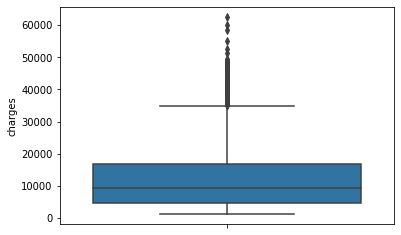

In [21]:
sns.boxplot(data=insight_df, y='charges')

Nhận xét: Biến charges có phân bố bị lệch trái, nhiều outlier

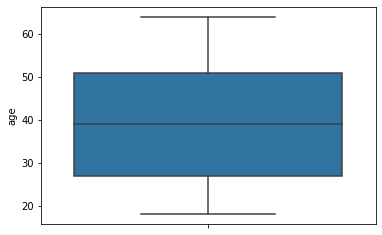

In [22]:
sns.boxplot(data=insight_df, y='age')

Nhận xét: Biến age có phân bố chuẩn

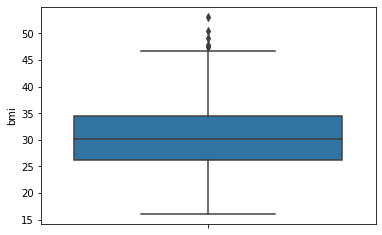

In [23]:
sns.boxplot(data=insight_df, y='bmi')

Nhận xét: Biến bmi có phân bố chuẩn, tồn tại outlier

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

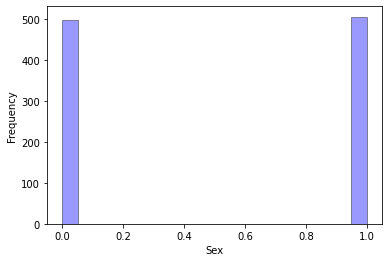

In [24]:
sns.distplot(insight_df['sex'], hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.xlabel('Sex')
plt.ylabel('Frequency')

Nhận xét: Tỉ lệ nam nữ bằng nhau

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

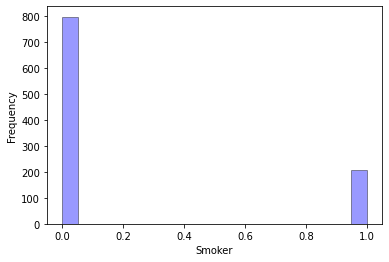

In [25]:
sns.distplot(insight_df['smoker'], hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.xlabel('Smoker')
plt.ylabel('Frequency')

Nhận xét: Tỉ lệ người không hút thuốc gấp 4 lần người hút thuốc

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

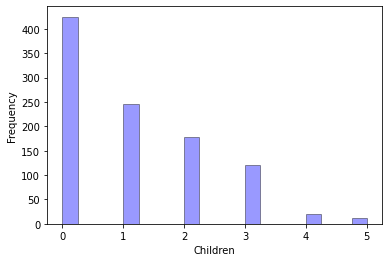

In [26]:
sns.distplot(insight_df['children'], hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.xlabel('Children')
plt.ylabel('Frequency')

Nhận xét: Tỉ lệ người có càng nhiều con giảm dần 

### Vẽ biểu đồ các biến tương quan và nhận xét

Tính ma trận tương quan

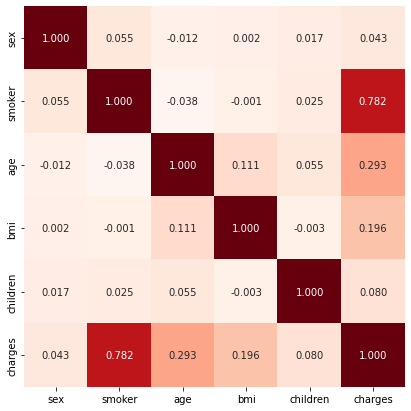

In [27]:
corr = insight_df.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr,square=True, annot=True, cbar=False, fmt='.3f', cmap='Reds')

Có thể thấy những thuộc tính như age (yếu), bmi (yếu), smoker (mạnh) có tương quan với thuộc tính charges

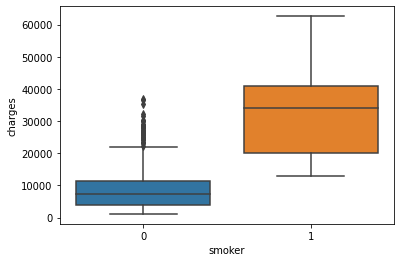

In [28]:
sns.boxplot(data=insight_df, x='smoker', y='charges')

Biểu đồ trên cho ta thấy người hút thuốc thì có chi phí y tế cao hơn, cụ thể :
- hơn 75% người hút thuốc trả chi phí cao hơn hầu hết tất cả người không hút thuốc
- chi phí thấp nhất của người hút thuốc chỉ nhỉnh hơn một chút so với chi phí của 75% người không hút thuốc.
- nếu chi phí dưới 10k, xác suất cao là người đó không hút thuốc
- nếu chi phí trên 20k, xác suất cao là người đó hút thuốc

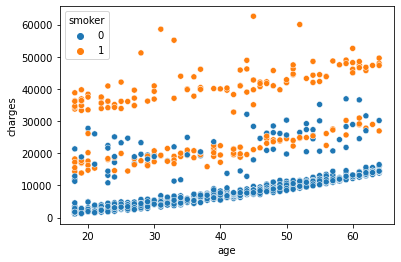

In [84]:
sns.scatterplot(data=insight_df, x='age', y='charges', hue='smoker')

Nhìn vào biểu đồ trên, ta thấy
- người càng cao tuổi thì số tiền chi cho y tế càng nhiều
- Nếu dưới 35 tuổi và không hút thuốc thì khả năng cao chi phí dưới 6k

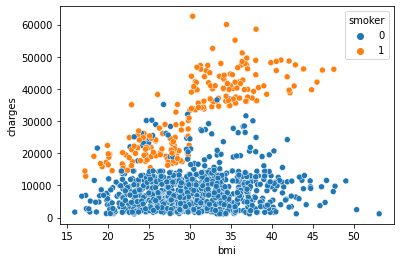

In [30]:
sns.scatterplot(data=insight_df, x='bmi', y='charges', hue='smoker')

- Người hút thuốc và có chỉ số BMI lớn hơn 30 thì chi phí tổi thiểu là khoảng 30k

### VIF

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = insight_X_no_object_df.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(insight_X_no_object_df.values, i)
                          for i in range(len(insight_X_no_object_df.columns))]
  
print(vif_data)

    feature       VIF
0       sex  1.966855
1    smoker  1.254563
2       age  7.658193
3       bmi  8.638958
4  children  1.816248


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1 = Không tương quan

Giữa 1 và 5 = Tương quan vừa

Lớn hơn 5 = Tương quan mạnh

(Tham khảo : [1])


Ta thấy các biến `sex`, `smoker`, `children` tương quan vừa với các biến còn lại. 

`age` và `bmi` có sự tương quan mạnh với các biến còn lại

Nên thu thập thêm data để giảm sự phụ thuộc giữa các biến

### Insight: Sex có ảnh hưởng đến Smoker?



${H_0}$: sex và smoker độc lập nhau

${H_A}$: sex và smoker phụ thuộc nhau

</br>

Đặt:

${A =}$  sex, ${A_1 =}$ `male`, ${A_2}$ = `female`

${B =}$ smoker, ${B_1 =}$ `yes`, ${B_2 =}$ `no`

</br>

Ta có:

${H_0}$: ${P(A_i\cap B_j) = P(A_i)P(B_j)}$

${H_A}$: ${P(A_i\cap B_j) \neq P(A_i)P(B_j)}$

</br>

Phần dưới sẽ trình bày về mặt toán học lẫn sử dụng thư viện scipy.stats để tính toán

</br>

In [32]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [33]:
insight_df_1 = insight_df.copy()
insight_df_1['sex'] = insight_df_1['sex'].replace(1,'male')
insight_df_1['sex'] = insight_df_1['sex'].replace(0,'female')
insight_df_1['smoker'] = insight_df_1['smoker'].replace(1,'yes')
insight_df_1['smoker']= insight_df_1['smoker'].replace(0,'no')

In [34]:
contigency= pd.crosstab(insight_df_1['sex'], insight_df_1['smoker']) 
contigency

smoker,no,yes
sex,,
female,406,91
male,391,115


In [35]:
contigency.columns = ['no', 'yes']

In [36]:
contigency['Pr(Ai)'] = contigency['no'] + contigency['yes']
sum_table = sum(contigency['Pr(Ai)'])
contigency['Pr(Ai)'] = contigency['Pr(Ai)']/sum_table
contigency

,no,yes,Pr(Ai)
sex,,,
female,406,91,0.495513
male,391,115,0.504487


In [37]:

Pr_No = sum(contigency['no'])/sum_table
Pr_Yes = sum(contigency['yes'])/sum_table

PrBj = [Pr_No,Pr_Yes]
print(f'Pr_No = {Pr_No}\nPr_Yes = {Pr_Yes}\n')
print(sum(PrBj))

Pr_No = 0.7946161515453639
Pr_Yes = 0.2053838484546361

1.0


Ta đã tính được ${Pr(A_i)}$ như bảng trên và 

${Pr(B_1)}$ = 0.2053838484546361

${Pr(B_2)}$ =  0.7946161515453639

---

Đến đây ta có thể tính:

Giá trị mong đợi ${E}$:

\begin{equation}
\text{Do kỳ vọng A và B độc lập:}\\
E_{ij} = Pr(A_i) \times Pr(B_j) \times N [2]\\
\text{hay}\\
E_{ij} = \frac{\text{(Tổng dòng} \times \text{Tổng cột)}}{\text{Tổng bảng}} [3]   \\ 
\text{với bảng là bảng contingency}
\end{equation}

Giá trị ${\chi^2}$:

\begin{equation}
\chi^2=\Sigma\frac{(O-E)^2}{E} [2][3]\\
\text{với O là giá trị thực sự và E là giá trị mong đợi}
\end{equation}

Giá trị dof: Degree of freedom

dof cho ${\chi^2}$ độc lập:

\begin{equation}
dof = v = rc - 1 - (r-1) - (c-1) = (r-1)(c-1) [2]\\ = 1
\end{equation}

Chọn mức ý nghĩa:

\begin{equation}
\alpha = 0.05
\end{equation}

Tra bảng Chi Squared với ${\alpha = 0.05, dof = 1}$ ta được critical value ${ = 3.841459}$	

Chấp nhận ${H_0}$ nếu 
\begin{equation}
\chi^2_v <= 3.841459
\end{equation}

</br>

Ta có thể sử dụng `chi2_contingency` của thư viện spicy để tính toán:


In [38]:
# [3]Source:  https://towardsdatascience.com/gentle-introduction-to-chi-square-test-for-independence-7182a7414a95
chi, pval, dof, expected = chi2_contingency(contigency.drop(['Pr(Ai)'],1))
print('p-value là: ', pval)
significance = 0.05
p = 1 - significance
critical_value = chi2.ppf(p, dof)
print('chi = %.6f, critical value = %.6f\n' % (chi, critical_value))
if chi > critical_value:
    print("""Với mức ý nghĩa %.2f, ta bác bỏ Ho và chấp nhận HA. 
Kết luận: sex và smoker không độc lập.""" % (significance))
else:
    print("""Với mức ý nghĩa %.2f, ta bác bỏ HA và chấp nhận H0. 
Kết luận: sex và smoker độc lập.""" % (significance))

p-value là:  0.09827321674727184
chi = 2.733346, critical value = 3.841459

Với mức ý nghĩa 0.05, ta bác bỏ HA và chấp nhận H0. 
Kết luận: sex và smoker độc lập.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [39]:
chi

2.7333457250617705

Ta kiểm tra, không dùng thư viện:

</br>

In [88]:
append_data = []
for sex in insight_df_1['sex'].unique():
  append_data.append(insight_df_1['smoker'][insight_df_1['sex'] == f'{sex}'].value_counts().rename_axis('smoker').reset_index(name='count'))
# items_df['Accidents'].value_counts().rename_axis('Accidents').reset_index(name='Frequency')
contigency_1 = pd.concat(append_data)
contigency_1.reset_index(inplace = True)
contigency_1

contigency_1['sex'] = np.nan
i = 0
pd.options.mode.chained_assignment = None  # default='warn'

for sex in insight_df_1['sex'].unique():
  contigency_1['sex'][i] = f'{sex}'
  contigency_1['sex'][i+1] = f'{sex}'
  i = i + 2

contigency_1 = contigency_1.reindex(columns = ['smoker', 'sex', 'count'])
contigency_1

,smoker,sex,count
0,no,male,391
1,yes,male,115
2,no,female,406
3,yes,female,91


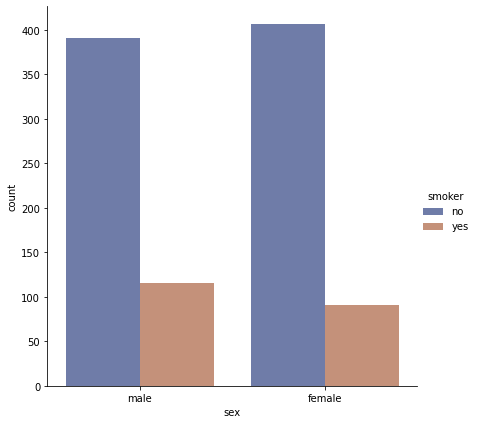

In [90]:
sns.catplot(
    data=contigency_1, kind="bar",
    x="sex", y="count", hue="smoker",
    ci="sd", palette="dark", alpha=.6, height=6
)

In [41]:
expectedValue = []

for Ai in contigency['Pr(Ai)'][::-1]: #female, male
  for Bj in PrBj: # no, yes
      expectedValue.append(Ai*Bj*sum_table)

chiij = []
oij = np.array(contigency_1['count'])

for ij in range(0, len(expectedValue)):
  chiij.append((oij[ij] - expectedValue[ij])**2/expectedValue[ij])

contigency_1['Expected value'] = expectedValue
contigency_1['(O_ij - E_ij)^2/E_ij'] = chiij

chi_square = sum(contigency_1['(O_ij - E_ij)^2/E_ij'])
print('chi_square = ', chi_square)
contigency_1.head()

chi_square =  2.997908815661011


,smoker,sex,count,Expected value,(O_ij - E_ij)^2/E_ij
0,no,male,391,402.075773,0.305099
1,yes,male,115,103.924227,1.180406
2,no,female,406,394.924227,0.310623
3,yes,female,91,102.075773,1.201781


Ta thấy:

\begin{equation}
\chi^2_v = 2.997908815661011 < 3.841459
\end{equation}

</br>

Vậy bác bỏ ${H_A}$ với mức ý nghĩa 0.05, chấp nhận ${H_0}$ 

</br>

<center><font size ="5">Kết luận: sex và smoker độc lập</font></center>

</br>

### Insight: Trung bình của 'age', 'bmi', 'children' giữa người có hút thuốc và người không hút thuốc có bằng nhau

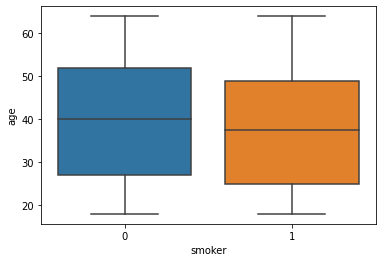

In [97]:
sns.boxplot(data=insight_df, x='smoker', y='age')

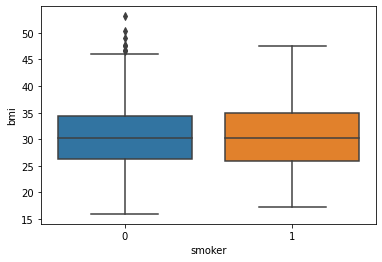

In [96]:
sns.boxplot(data=insight_df, x='smoker', y='bmi')

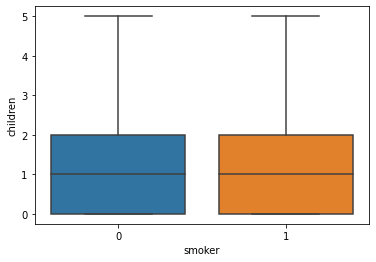

In [98]:
sns.boxplot(data=insight_df, x='smoker', y='children')

In [42]:
numeric_features = ['age', 'bmi', 'children']


In [43]:
from statsmodels.stats.weightstats import ztest

significance = 0.05

for i in range(len(numeric_features)):
    
    print(f'\nHo: trung bình `{numeric_features[i]}` của người có hút thuốc = trung bình `{numeric_features[i]}` của người không hút thuốc\n')
    print(f'\nHa: trung bình `{numeric_features[i]}` của người có hút thuốc khác trung bình `{numeric_features[i]}` của người không hút thuốc\n')
    stat, p = ztest(insight_df[numeric_features[i]][insight_df['smoker'] == 1],insight_df[numeric_features[i]][insight_df['smoker'] == 0])
    print('stat=%.3f, p=%.3f' % (stat, p))
    print('\nKẾT LUẬN: ')
    if p >= significance:
      print(f'Với mức ý nghĩa {significance}, ta chấp nhận Ho, bác bỏ Ha.\nTrung bình `{numeric_features[i]}` của người có hút thuốc = trung bình `{numeric_features[i]}` của người không hút thuốc\n---')
    else:
      print(f'Với mức ý nghĩa {significance}, ta chấp nhận Ha, bác bỏ Ho.\nTrung bình `{numeric_features[i]}` của người có hút thuốc khác trung bình `{numeric_features[i]}` của người không hút thuốc\n---')


Ho: trung bình `age` của người có hút thuốc = trung bình `age` của người không hút thuốc


Ha: trung bình `age` của người có hút thuốc khác trung bình `age` của người không hút thuốc

stat=-1.200, p=0.230

KẾT LUẬN: 
Với mức ý nghĩa 0.05, ta chấp nhận Ho, bác bỏ Ha.
Trung bình `age` của người có hút thuốc = trung bình `age` của người không hút thuốc
---

Ho: trung bình `bmi` của người có hút thuốc = trung bình `bmi` của người không hút thuốc


Ha: trung bình `bmi` của người có hút thuốc khác trung bình `bmi` của người không hút thuốc

stat=-0.047, p=0.962

KẾT LUẬN: 
Với mức ý nghĩa 0.05, ta chấp nhận Ho, bác bỏ Ha.
Trung bình `bmi` của người có hút thuốc = trung bình `bmi` của người không hút thuốc
---

Ho: trung bình `children` của người có hút thuốc = trung bình `children` của người không hút thuốc


Ha: trung bình `children` của người có hút thuốc khác trung bình `children` của người không hút thuốc

stat=0.807, p=0.420

KẾT LUẬN: 
Với mức ý nghĩa 0.05, ta chấp nhận Ho, bác bỏ Ha.

### Insight: Sự phụ thuộc của `charges` vào `sex`, `smoker`, `age`, `bmi`, `children`

In [44]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [45]:
results = sm.OLS(y, sm.add_constant(insight_X_no_object_df)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     580.0
Date:                Sun, 03 Apr 2022   Prob (F-statistic):          3.98e-292
Time:                        04:33:27   Log-Likelihood:                -10164.
No. Observations:                1003   AIC:                         2.034e+04
Df Residuals:                     997   BIC:                         2.037e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.23e+04   1121.474    -10.968      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


</br> 

Kết luận:

- Biến `sex` không có ý nghĩa (có thể loại bỏ)
- Biến `smoker` có ý nghĩa đối với mô hình về mặt thống kê (với mức ý nghĩa (***) hay p-value = 0.000)
- Biến `age` có ý nghĩa đối với mô hình về mặt thống kê (với mức ý nghĩa (***) hay p-value = 0.000)
- Biến `bmi` có ý nghĩa đối với mô hình về mặt thống kê (với mức ý nghĩa (***) hay p-value = 0.000)
- Biến `children` không có ý nghĩa (có thể loại bỏ)
- Mô hình có thể giải thích được 74.3% sự thay đổi của biến `charges`
- Mô hình tương đối tốt (p-value = 1.78e-129)

Ta huấn luyện lại mô hình dựa theo kết luận trên

In [46]:
results = sm.OLS(y, sm.add_constant(insight_X_no_object_df.drop(['sex', 'children'],1))).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     959.1
Date:                Sun, 03 Apr 2022   Prob (F-statistic):          1.63e-293
Time:                        04:33:28   Log-Likelihood:                -10168.
No. Observations:                1003   AIC:                         2.034e+04
Df Residuals:                     999   BIC:                         2.036e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.185e+04   1097.537    -10.799      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [47]:
print('Parameters: ', results.params)

Parameters:  const    -11852.720452
smoker    23668.497446
age         262.144961
bmi         326.725200
dtype: float64


Ta thấy:

- Cứ tăng 1 tuổi thì chi phí y tế cá nhân tăng 262.144961, tăng 1 chỉ số bmi thì tăng 326.725200 chi phí y tế cá nhân
- Riêng với smoker, người có hút thuốc thì có chi phí y tế cá nhân cao hơn người không hút thuốc đến 23668.497446


## TIỀN XỬ LÝ + MÔ HÌNH HÓA

reference: [machinelearningmastery](https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/)

### Sử dụng SVR với kernel non-linear: RBF (mặc định)

### Chọn tham số cho mô hình

#### Hàm svr_r2

Hàm này để tính độ chính xác trung bình khi sử dụng phương pháp đánh giá lỗi K-fold của 1 bộ tham số C, gamma

In [48]:
def svr_r2(X, y, kernel, C, gamma, cv):
  svr = SVR(kernel=kernel, C=C, gamma=gamma)
  pipeline = Pipeline(steps=[('Column Transformer', preprocessor), ('model', svr),])
  model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
  scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
  return np.mean(scores)

#### Hàm optimal_svr 

Để chọn ra chọn siêu tham số làm cho mô hình có độ chính xác cao nhất trên tập huấn luyện

In [49]:
def optimal_svr(X, y, kernel, c_range, gamma_range, train_r2=[]):
  max_score = 0
  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  for c in c_range:
    scores = []
    for g in gamma_range:
      score = svr_r2(X, y, kernel, c, g, cv)
      scores.append(score)
      if score > max_score:
        max_score = score
        res = (c, g)
    train_r2.append(scores)
  return res


In [50]:
C_range = [0.05,0.1,1,10, 50]
gamma_range = [0.01,0.05,0.1,1,10]
kernel = 'rbf'
train_r2 = []
best_c, best_g = optimal_svr(X, y, kernel, C_range, gamma_range, train_r2)

#### Trực quan kết quả

In [51]:
train_r2 = pd.DataFrame(train_r2, columns=gamma_range, index=C_range)

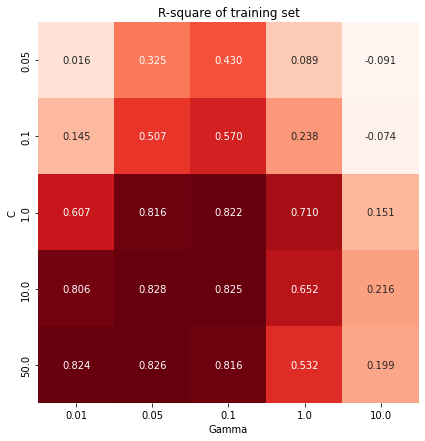

In [52]:
plt.figure(figsize=(7, 7))
sns.heatmap(train_r2,square=True, annot=True, cbar=False, fmt='.3f', cmap='Reds')
plt.xlabel('Gamma'); plt.ylabel('C');plt.title('R-square of training set')
plt.show()

Vậy các tham số tìm được là:

In [53]:
print('C= %s và gamma= %s' %(best_c, best_g))

C= 10 và gamma= 0.05


### Dùng các siêu tham số tìm được ở trên để huấn luyện mô hình

In [54]:
df_test = pd.read_csv('test.csv')
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]

In [55]:
svr = SVR(kernel= kernel, C=best_c, gamma=best_g)
pipeline = Pipeline(steps=[('Column Transformer', preprocessor), ('model', svr),])
model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
model.fit(X,y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('Column Transformer',
                                                      ColumnTransformer(transformers=[('ordinals',
                                                                                       Pipeline(steps=[('imputer_cat',
                                                                                                        SimpleImputer(strategy='constant')),
                                                                                                       ('ordinal',
                                                                                                        OrdinalEncoder())]),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('onehot',
                                                                                       Pipeline(steps=[('imputer_cat',
                                                                                                        SimpleImputer(strategy='constant')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['region']),
                                                                                      ('numericals',
                                                                                       Pipeline(steps=[('imputer_num',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      SVR(C=10, gamma=0.05))]),
                           transformer=StandardScaler())

In [56]:
preds = model.predict(X_test)

In [57]:
score = model.score(X_test,y_test)
score

0.8565700319583182

### Sử dụng SVR với kernel linear

#### Lựa chọn siêu tham số tốt nhất cho mô hình

In [58]:
kernel = 'linear'
train_r2 = []
best_c, best_g = optimal_svr(X, y, kernel, C_range, gamma_range, train_r2)

#### Trực quan kết quả

In [59]:
train_r2 = pd.DataFrame(train_r2, columns=gamma_range, index=C_range)

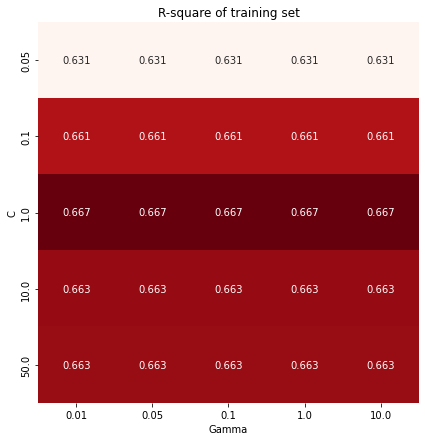

In [60]:
plt.figure(figsize=(7, 7))
sns.heatmap(train_r2,square=True, annot=True, cbar=False, fmt='.3f', cmap='Reds')
plt.xlabel('Gamma'); plt.ylabel('C');plt.title('R-square of training set')
plt.show()

Vậy các siêu tham số tốt nhất tìm được là:

In [61]:
print('C= %s và gamma= %s' %(best_c, best_g))

C= 1 và gamma= 0.01


**Nhận xét:** 
- Siêu tham số gamma chỉ có giá trị trong các mô hình phi tuyến (bao gồm: ‘rbf’, ‘poly’ và ‘sigmoid’) 

#### Dùng các siêu tham số tìm được để huấn luyện mô hình

In [62]:
svr = SVR(kernel= kernel, C=best_c, gamma=best_g)
pipeline = Pipeline(steps=[('Column Transformer', preprocessor), ('model', svr),])
model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
model.fit(X,y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('Column Transformer',
                                                      ColumnTransformer(transformers=[('ordinals',
                                                                                       Pipeline(steps=[('imputer_cat',
                                                                                                        SimpleImputer(strategy='constant')),
                                                                                                       ('ordinal',
                                                                                                        OrdinalEncoder())]),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('onehot',
                                                                                       Pipeline(steps=[('imputer_cat',
                                                                                                        SimpleImputer(strategy='constant')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['region']),
                                                                                      ('numericals',
                                                                                       Pipeline(steps=[('imputer_num',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      SVR(C=1, gamma=0.01,
                                                          kernel='linear'))]),
                           transformer=StandardScaler())

In [63]:
preds = model.predict(X_test)

In [64]:
score = model.score(X_test,y_test)
score

0.7264543523698547

**Nhận xét:**
- Ta thấy vấn đề dự đoán chi phí y tế được giải quyết tốt hơn trên mô hình phi tuyến 
- Thuật toán SVR ở kernel phi tuyến cho độ chính xác cao hơn rất nhiều so với kernel tuyến tính
- Độ chính xác của mô hình còn khá thấp, nên ta thử các các tối ưu khác

### Sử dụng mô hình SVR với kernel non-linear trên dữ liệu được xóa outliers

Từ biểu đồ hộp ở phần phân tích dữ liệu, ta thấy ở các bệnh nhân không hút thuốc thì có sự biến động khá lớn trong chi phí điều trị bệnh. Có thể những người này mắc các bệnh bẩm sinh hoặc không liên quan đến thuốc lá. 

Giả sử các bệnh nhân không hút thuốc có chi phí điều trị bệnh cao bất thường là các outliers ta tiến hành xóa các bệnh nhân này ra khỏi tập huấn luyện

Theo biểu đồ hộp, thì khoảng lớn hơn 1.5 lần ipr là các outliers

In [65]:
q25 = train_df[train_df.smoker == 'no']['charges'].agg(lower_quartile)
q75 = train_df[train_df.smoker == 'no']['charges'].agg(upper_quartile)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

#### Xóa các outliers

In [66]:
removed_outliers = train_df[((train_df.smoker == 'no') & (train_df.charges > lower) & (train_df.charges < upper)) | (train_df.smoker == 'yes')]

Ta xem lại biểu đồ để xác nhận không còn những điểm outliers

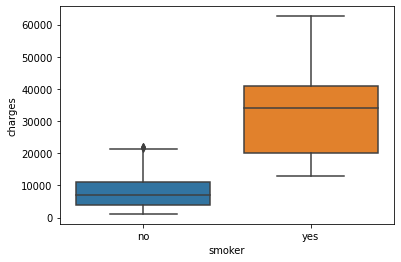

In [67]:
sns.boxplot(data= removed_outliers, x='smoker', y='charges');

Tách tập train đã bỏ các outlier 

In [68]:
removed_outliers_X, removed_outliers_y = removed_outliers.iloc[:, :-1], removed_outliers.iloc[:, -1]

#### Tìm các siêu tham số tốt nhất với dữ liệu hiện tại

Các bước thực hiện tương tự như trên

In [69]:
kernel = 'rbf'
train_r2 = []
best_c, best_g = optimal_svr(removed_outliers_X, removed_outliers_y, kernel, C_range, gamma_range, train_r2)

In [70]:
train_r2 = pd.DataFrame(train_r2, columns=gamma_range, index=C_range)

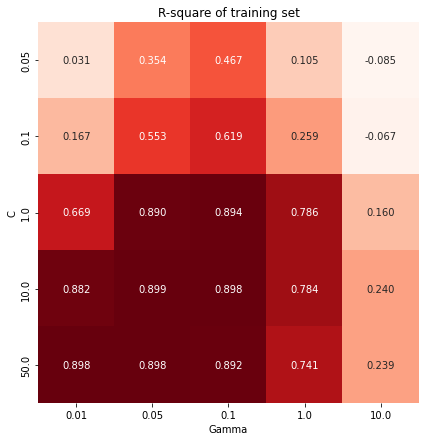

In [71]:
plt.figure(figsize=(7, 7))
sns.heatmap(train_r2,square=True, annot=True, cbar=False, fmt='.3f', cmap='Reds')
plt.xlabel('Gamma'); plt.ylabel('C');plt.title('R-square of training set')
plt.show()

In [72]:
print('C= %s và gamma= %s' %(best_c, best_g))

C= 10 và gamma= 0.05


In [73]:
svr = SVR(kernel= kernel, C=best_c, gamma=best_g)
pipeline = Pipeline(steps=[('Column Transformer', preprocessor), ('model', svr),])
model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
model.fit(removed_outliers_X,removed_outliers_y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('Column Transformer',
                                                      ColumnTransformer(transformers=[('ordinals',
                                                                                       Pipeline(steps=[('imputer_cat',
                                                                                                        SimpleImputer(strategy='constant')),
                                                                                                       ('ordinal',
                                                                                                        OrdinalEncoder())]),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('onehot',
                                                                                       Pipeline(steps=[('imputer_cat',
                                                                                                        SimpleImputer(strategy='constant')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['region']),
                                                                                      ('numericals',
                                                                                       Pipeline(steps=[('imputer_num',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      SVR(C=10, gamma=0.05))]),
                           transformer=StandardScaler())

In [74]:
preds = model.predict(X_test)
score = model.score(X_test,y_test)
score

0.8532437921534918

**Nhận xét:**
- Khi xóa các dữ liệu bệnh nhân bất thường thì độ chính xác trên tập train tăng lên đến gần 90%
- Tuy nhiên khi dự đoán trên tập test thì độ chính xác của mô hình không tăng mà lại thấp đi một chút
- Có vẻ là lớp bệnh nhân này cũng có tỉ lệ cao trong thực tế nên nó không hẵn là các outlier mà có thể là các đối tượng khá đặc biệt mà cần quan sát thêm các đặc trưng khác để có thể dự đoán chính xác

### Dùng Simple Regression

In [75]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
pipeline = Pipeline(steps=[('Column Transformer', preprocessor), ('model', reg),])
model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
model.fit(X,y)
model.score(X, y)

0.744221765190394

In [76]:
model

TransformedTargetRegressor(regressor=Pipeline(steps=[('Column Transformer',
                                                      ColumnTransformer(transformers=[('ordinals',
                                                                                       Pipeline(steps=[('imputer_cat',
                                                                                                        SimpleImputer(strategy='constant')),
                                                                                                       ('ordinal',
                                                                                                        OrdinalEncoder())]),
                                                                                       ['sex',
                                                                                        'smoker']),
                                                                                      ('onehot',
                                                                                       Pipeline(steps=[('imputer_cat',
                                                                                                        SimpleImputer(strategy='constant')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['region']),
                                                                                      ('numericals',
                                                                                       Pipeline(steps=[('imputer_num',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['age',
                                                                                        'bmi',
                                                                                        'children'])])),
                                                     ('model',
                                                      LinearRegression())]),
                           transformer=StandardScaler())

In [77]:
preds = model.predict(X_test)

In [78]:
score = model.score(X_test,y_test)
score

0.7658201226718288

#### Giảm chiều và trực quan

In [79]:
Xpre = preprocessor.fit_transform(X)

In [80]:
pls = PLSRegression(n_components=1)
pls.fit(Xpre, y)

PLSRegression(n_components=1)

In [81]:
X_test_pre = preprocessor.transform(X_test)

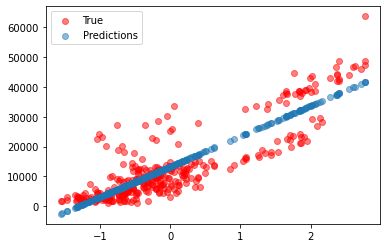

In [82]:
plt.scatter(x=pls.transform(X_test_pre), y= y_test, alpha = 0.5,color= 'r', label= 'True')
plt.scatter(x=pls.transform(X_test_pre), y = pls.predict(X_test_pre), alpha= 0.5, label= 'Predictions')
plt.legend()
plt.show()

### Kết luận:

- Đối với dữ liệu này, trong các mô hình được thực hiện thì mô hình SVR với kernel là RBF cho độ chính xác cao nhất là khoảng 86% trên tập test và lên đến 90% trên tập train khi xóa đi các bệnh nhân không hút thuốc nhưng chi phí y tế cao
- Đối tượng bệnh nhân không hút thuốc nhưng lại mất nhiều chi phí cho dịch vụ y tế cần được quan sát thêm các đặc trưng để dự đoán được chính xác hơn

## Tham khảo

[1]. [Stephanie - Variance Inflation Factor - Statisticshowto.com](https://www.statisticshowto.com/variance-inflation-factor/)

[2]. https://www3.nd.edu/~rwilliam/stats1/x51.pdf

[3]. https://towardsdatascience.com/gentle-introduction-to-chi-square-test-for-independence-7182a7414a95